In [1]:
import pandas as pd
import numpy as  np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as mse
import random
from sklearn.model_selection import train_test_split
from google.colab import files
#tf.compat.v1.enable_eager_execution()
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 10)
inp_data_params = 5

In [2]:
!rm -rf Design2b*
files.upload()
data = pd.read_csv("Design2b_para1_S21.csv")
data_points_initially = data.shape[1]-1

In [3]:
def input_parameters(data):
    output=np.empty((0,inp_data_params), float)
    for columns in data.columns[1:]:
        params=columns.split(' ')[3:]
        param=[]
        for vals in params:
            param.append(float(vals.split('=')[1][1:-3]))
        param=np.array([param])
        output=np.concatenate((output, param), axis=0)
    return output

In [4]:
def clean_data(data):
  data=data.replace([-np.inf], np.nan)
  data=data.dropna(axis=1, how='all')
  data.isnull().to_numpy().any()
  drop_columns = []
  data = data.drop(columns=drop_columns)
  return data

In [5]:
data = clean_data(data)
X = input_parameters(data)
X

array([[10. ,  0. ,  0.5,  0.5,  0.1],
       [10. ,  0. ,  1. ,  0.5,  0.1],
       [10. ,  0. ,  1.5,  0.5,  0.1],
       ...,
       [14. ,  0.2,  2. ,  2. ,  0.5],
       [14. ,  0.2,  2.5,  2. ,  0.5],
       [14. ,  0.2,  3. ,  2. ,  0.5]])

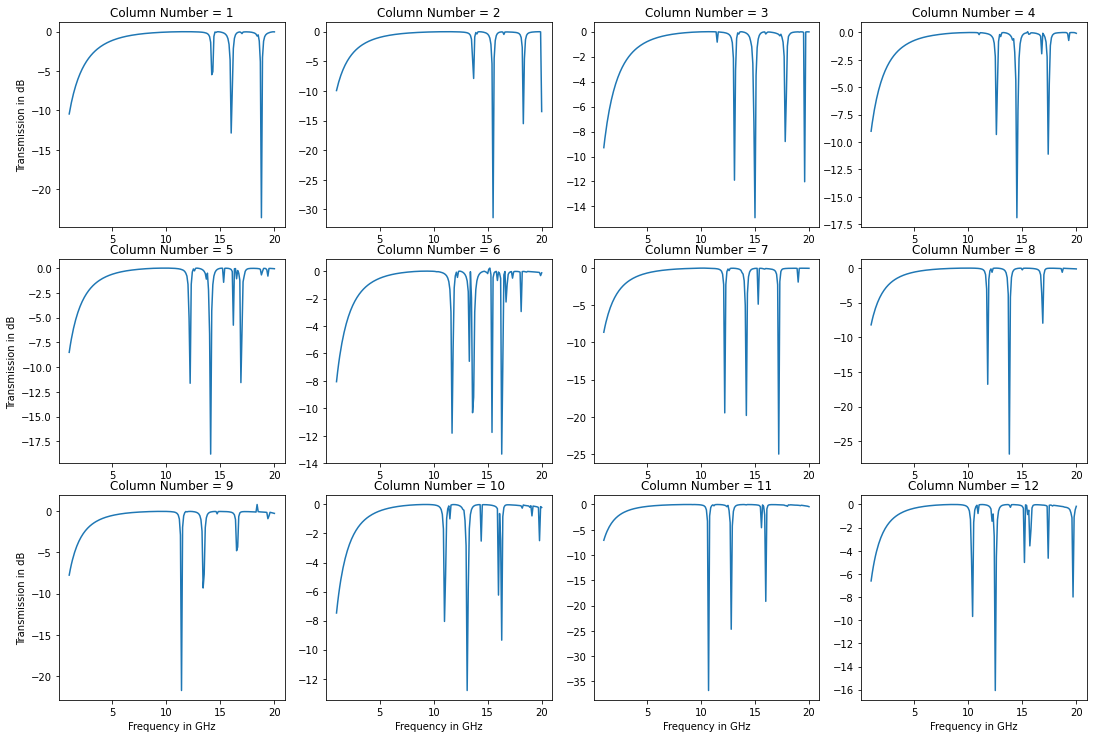

In [6]:
rows = 3
columns = 4
fig, window =  plt.subplots(rows, columns, figsize=(15,10))
fig.tight_layout()
for x in range(0,rows):
    for y in range(0, columns):
        index=1+x*columns+y
        window[x][y].title.set_text("Column Number = %d" % index)
        window[x][y].plot(data.iloc[:, 0], data.iloc[:, index])
plt.setp(window[-1, :], xlabel='Frequency in GHz');
plt.setp(window[:, 0], ylabel='Transmission in dB');

In [7]:
data

,Freq [GHz],"dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='10mm' g2='0mm' s1='0.5mm' s2='0.5mm' w1='0.1mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='10mm' g2='0mm' s1='1mm' s2='0.5mm' w1='0.1mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='10mm' g2='0mm' s1='1.5mm' s2='0.5mm' w1='0.1mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='10mm' g2='0mm' s1='2mm' s2='0.5mm' w1='0.1mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='10mm' g2='0mm' s1='2.5mm' s2='0.5mm' w1='0.1mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='10mm' g2='0mm' s1='3mm' s2='0.5mm' w1='0.1mm'",...,"dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='12mm' g2='0.2mm' s1='3mm' s2='2mm' w1='0.5mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='14mm' g2='0.2mm' s1='0.5mm' s2='2mm' w1='0.5mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='14mm' g2='0.2mm' s1='1mm' s2='2mm' w1='0.5mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='14mm' g2='0.2mm' s1='1.5mm' s2='2mm' w1='0.5mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='14mm' g2='0.2mm' s1='2mm' s2='2mm' w1='0.5mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='14mm' g2='0.2mm' s1='2.5mm' s2='2mm' w1='0.5mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='14mm' g2='0.2mm' s1='3mm' s2='2mm' w1='0.5mm'"
0,1.0,-10.442753,-9.940730,-9.292465,-9.014386,-8.513393,-8.059686,...,-12.859443,-10.627592,-12.091852,-14.938296,-17.586334,-19.330456,-23.733522
1,1.1,-9.686104,-9.193378,-8.559164,-8.290056,-7.799136,-7.358343,...,-16.985468,-13.660589,-15.874508,-20.728349,-26.521303,-33.686894,-33.477599
2,1.2,-9.007055,-8.524151,-7.904662,-7.644506,-7.164511,-6.737066,...,-24.337930,-18.058373,-22.152383,-39.365613,-30.092042,-24.458219,-19.976332
3,1.3,-8.393755,-7.921121,-7.316903,-7.065565,-6.597278,-6.183479,...,-36.573407,-26.508274,-64.737982,-23.796480,-19.681245,-17.463882,-15.256272
4,1.4,-7.836918,-7.374927,-6.786405,-6.543653,-6.087776,-5.687796,...,-21.392828,-31.795145,-22.881097,-17.438132,-15.364167,-13.898110,-12.437187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,19.6,-0.091475,-0.013326,-12.022328,-0.006446,-0.035012,-0.083172,...,-2.164393,-0.478119,-1.063202,-3.536062,-7.345605,-0.032263,-0.351818
187,19.7,-0.056626,-0.007443,-0.035635,-0.011400,-0.039860,-0.092064,...,-0.726534,-0.633057,-1.409890,-0.839340,-1.406894,-0.089562,-0.549929
188,19.8,-0.033194,-0.006752,-0.015408,-0.011111,-0.047368,-0.104445,...,-1.698077,-0.818473,-2.188420,-5.994927,-0.093312,-0.201650,-0.968105
189,19.9,-0.023166,-0.037106,-0.015557,-0.035023,-0.056540,-0.331014,...,-3.758136,-1.057430,-4.460481,-5.385334,-0.056496,-0.334468,-0.981595


In [8]:
trans_cutoff = -0.45
output_data = np.empty((0,2),float)
index_range = np.empty((0,2), int)
indices = []
input_data = np.empty((0,inp_data_params), float)
ignore_subsequent_cutoffs = True
for column in range(1, data.shape[1]):
  cutoff_index_curr = []
  first_cutoff_found = False
  for index in range(1, data.shape[0]):
    prev = data.iloc[index-1,column]
    curr = data.iloc[index,column]
    if prev < trans_cutoff and curr >= trans_cutoff \
    and not first_cutoff_found:
      cutoff_index_curr.append(index)
      first_cutoff_found = True
    if prev >= trans_cutoff and curr < trans_cutoff \
    and first_cutoff_found:
      cutoff_index_curr.append(index-1)
      first_cutoff_found = False
  if len(cutoff_index_curr) <= 1:
    continue
  elif len(cutoff_index_curr) % 2 != 0:
    cutoff_index_curr = cutoff_index_curr[0:-1]
  #print(cutoff_index_curr)
  cutoff_index_curr = np.array(cutoff_index_curr)
  cutoff_index_curr = cutoff_index_curr.reshape(-1, 2)
  if ignore_subsequent_cutoffs:
    cutoff_index_curr = cutoff_index_curr[0:1]
  for cutoff in cutoff_index_curr:
      indices.append(column)
      input_data = np.concatenate((input_data, X[column-1:column]))
      op_curr = np.array([data.iloc[cutoff, 0].to_numpy()])
      output_data = np.concatenate((output_data, op_curr))
  index_range= np.concatenate((index_range, cutoff_index_curr))
# print(output_data)
# print(index_range)
# print(input_data)
# print(indices)
print('''Total data points = %d
Useful data points = %d
Loss in data points = %d'''
%(data_points_initially, len(indices),
data_points_initially-len(indices)))

Total data points = 648
Useful data points = 648
Loss in data points = 0


In [9]:
use_old_method_of_data_cleaning = False
if use_old_method_of_data_cleaning:
  output_data = np.empty((0,2),float)
  index_range = np.empty((0,2), int)
  indices = []
  input_data = np.empty((0,inp_data_params), float)
  r = -0.45
  r1 = -0.30
  r2 = -0.30
  rmin = -0.10
  for index in range(1, data.shape[1]):
      temp = []
      ix = []
      freq = []
      found = False
      for i, val in enumerate(data.iloc[:, index]):
          if r <= val:
              found = True
              temp.append(val)
              ix.append(i)
              freq.append(data.iloc[i, 0])
              continue
          if found:
              break
      if len(temp) >= 2 and temp[0] < r1 and temp[-1] < r2 and max(temp) > rmin:
          freq = np.array([[freq[0], freq[-1]]])
          ix = np.array(([[ix[0], ix[-1]]]))
          indices.append(index)
          index_range = np.concatenate((index_range, ix))
          output_data = np.concatenate((output_data, freq))
          input_data = np.concatenate((input_data, X[index-1:index]))
  # print(output_data)
  # print(index_range)
  # print(input_data)
  # print(indices)
  print('''Total data points = %d
  Useful data points = %d
  Loss in data points = %d'''
  %(data.shape[1]-1, len(indices),
  data.shape[1]-1-len(indices)))

In [10]:
dic = {}
for op in output_data:
  if dic.get(str(op), -1) == -1:
    dic[str(op)] = 1
  else:
    dic[str(op)] = dic[str(op)] + 1
freq_dic = {}
for key, value in dic.items():
  if freq_dic.get(value, -1) == -1:
    freq_dic[value] = 1
  else:
    freq_dic[value] = freq_dic[value] + 1
for key, value in freq_dic.items():
  print("output pairs repeating %d times = %d" % (key, value))

output pairs repeating 2 times = 106
output pairs repeating 3 times = 59
output pairs repeating 1 times = 225
output pairs repeating 6 times = 1
output pairs repeating 4 times = 7


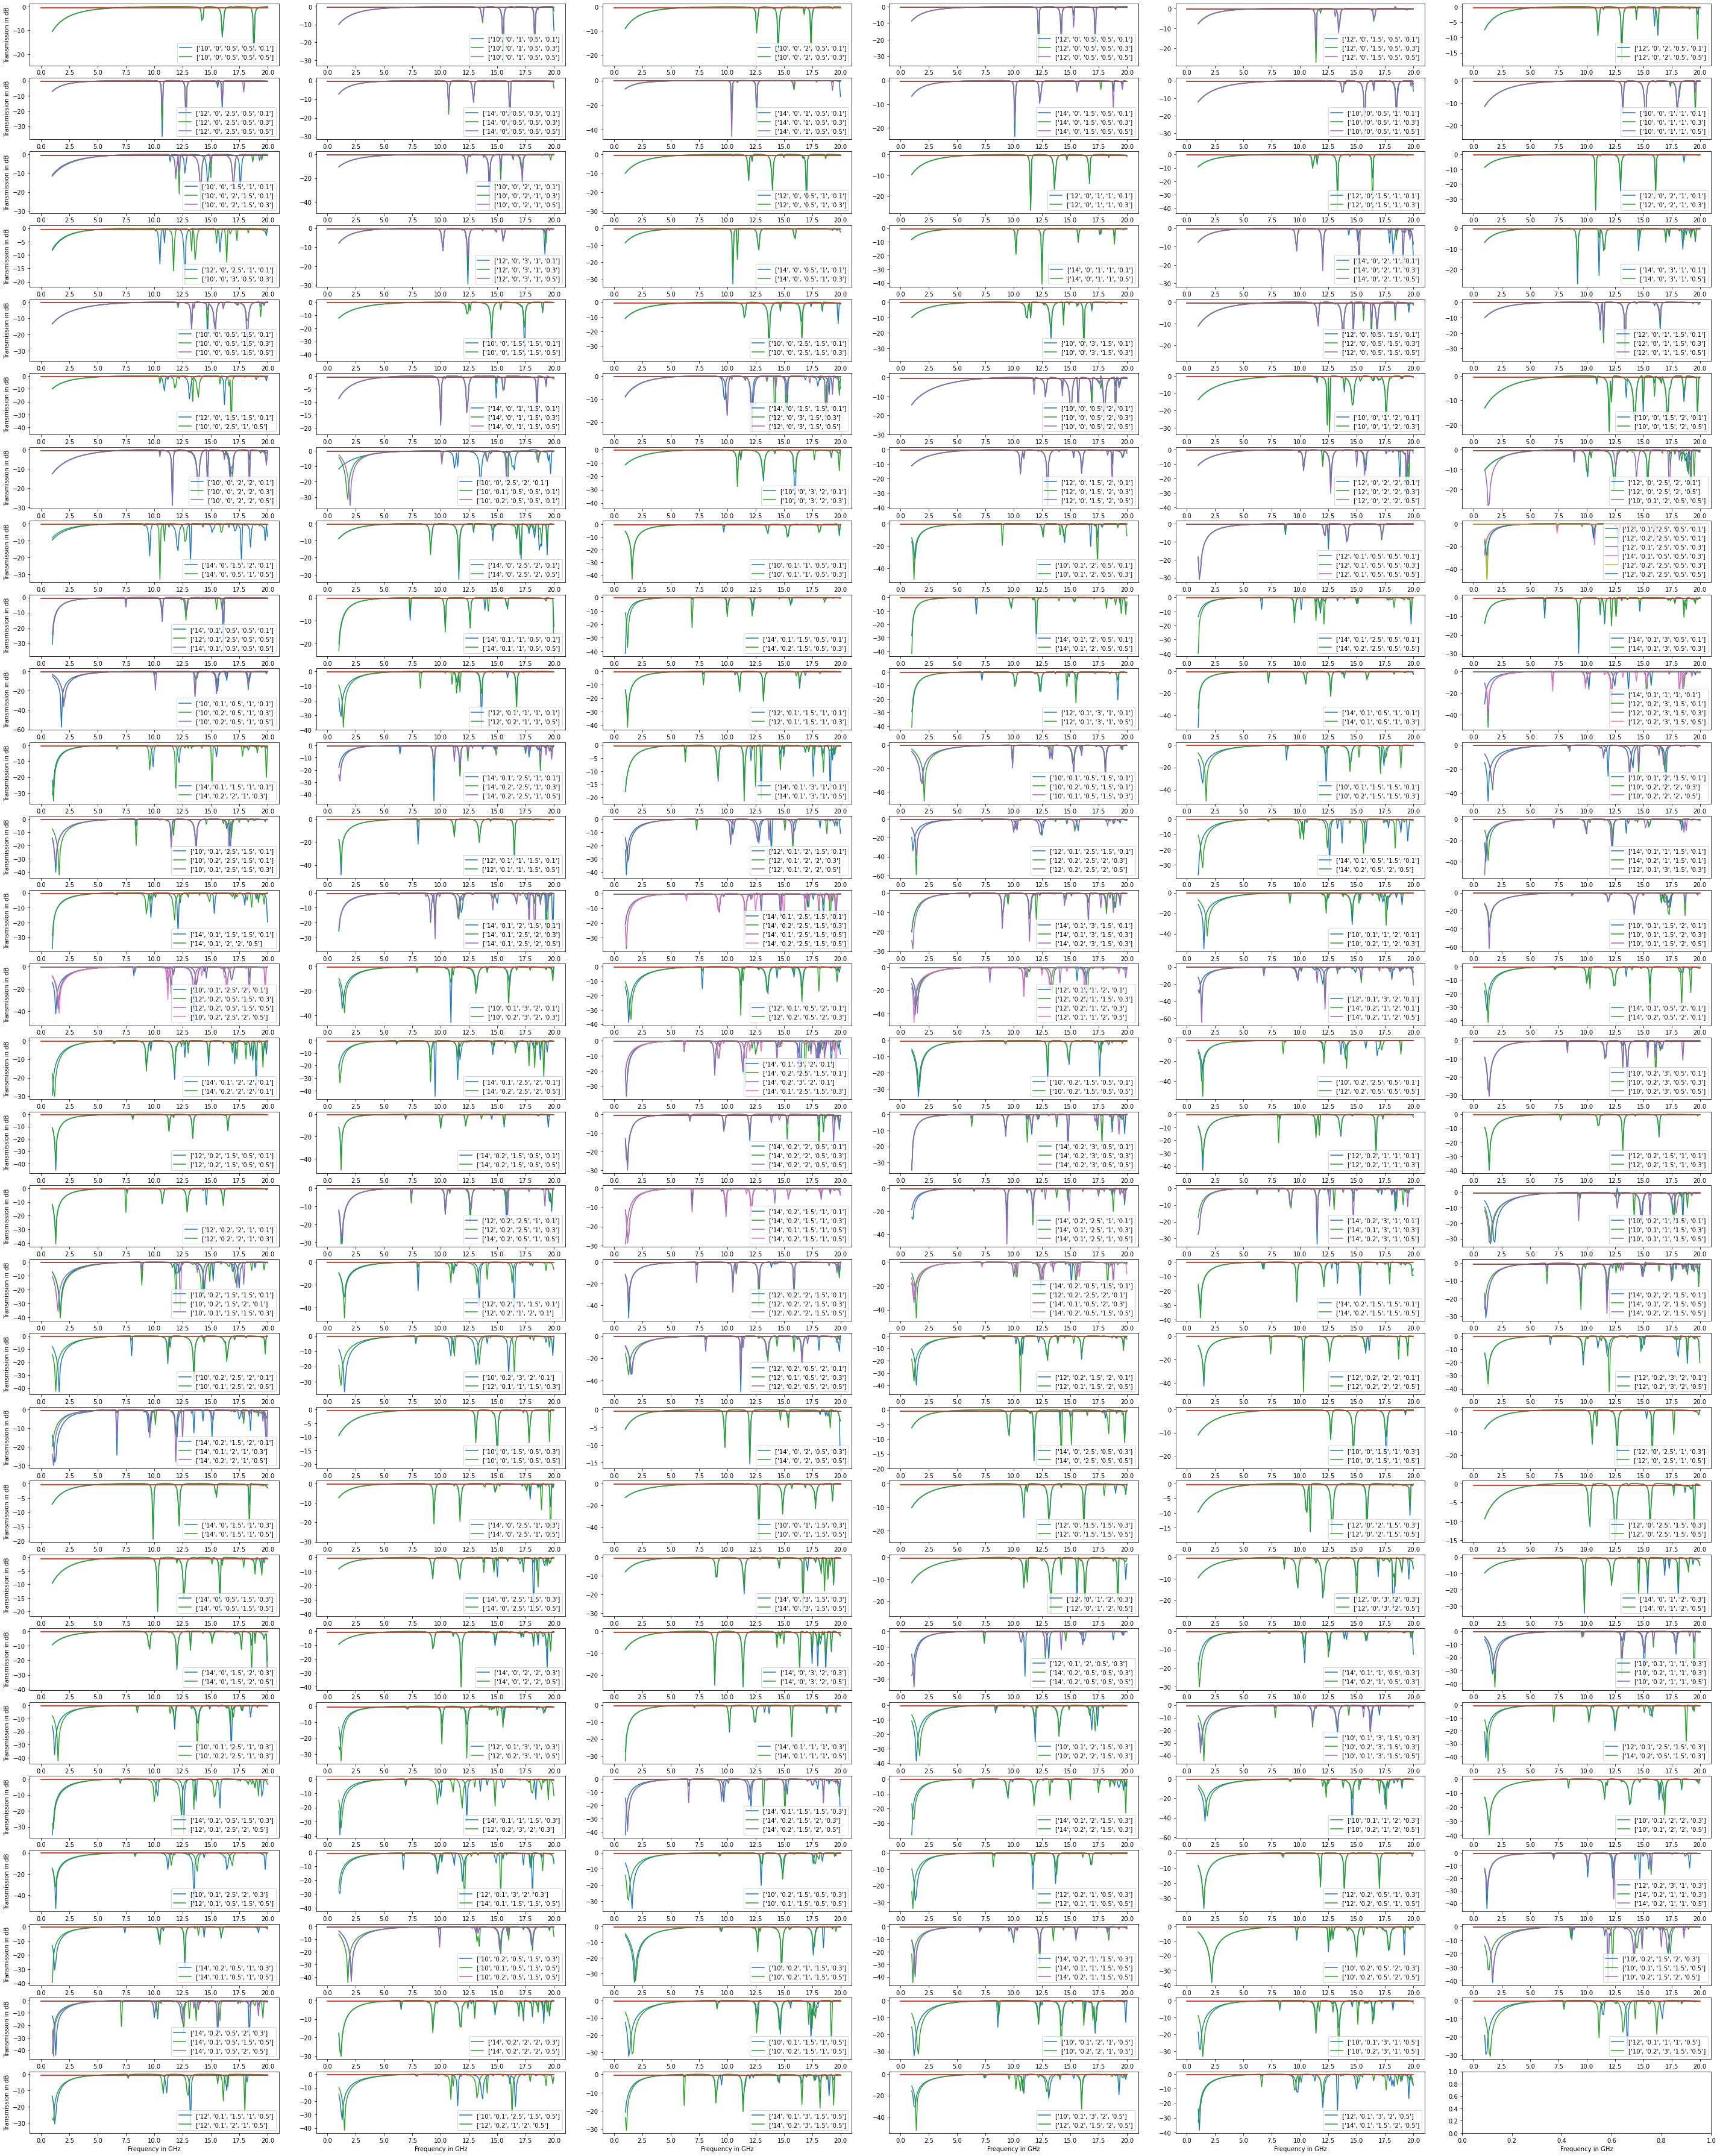

In [11]:
dic = {}
for index in range(0, output_data.shape[0]):
  if dic.get(str(output_data[index]), -1) == -1:
    dic[str(output_data[index])] = [list(input_data[index])]
  else:
    dic[str(output_data[index])].append(list(input_data[index]))
rep_dic={}
for key, elements in dic.items():
    if len(elements) > 1:
      rep_dic[key] = []
      for element in elements:
        l = []
        for val in element:
          if int(val) == val:
            l.append(str(int(val)))
          else:
            l.append(str(val))
        rep_dic [key].append(l)
final_dic = {}
for key, elements in rep_dic.items():
  final_dic[key] = []
  for element in elements:
    if inp_data_params == 4:
      final_dic[key].append("dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='%smm' g2='%smm' s1='%smm' s2='%smm'"%(tuple(element)))
    if inp_data_params == 5:
      final_dic[key].append("dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='%smm' g2='%smm' s1='%smm' s2='%smm' w1='%smm'"%(tuple(element)))
Plot = True
if Plot:
  rows = 29
  columns = 6
  fig, window =  plt.subplots(rows, columns, figsize=(50,65))
  plt.subplots_adjust(wspace=0.15, hspace=0.20)
  number = 0
  for key, elements in final_dic.items():
    col = number % columns
    row = number // columns
    number = number + 1
    for index, element in enumerate(elements):
      window[row][col].plot(data.iloc[:,0], data[element], label=str(rep_dic[key][index]))
      window[row][col].plot([0,20], [-0.45, -0.45])
    window[row][col].legend(loc ="lower right") 
    # window[row][col].title.set_text(str(rep_dic[key][0:2]))
  plt.setp(window[-1, :], xlabel='Frequency in GHz')
  plt.setp(window[:, 0], ylabel='Transmission in dB')
# for key, elements in rep_dic.items():
#     print(elements)

Text(0, 0.5, 'Transmission in dB')

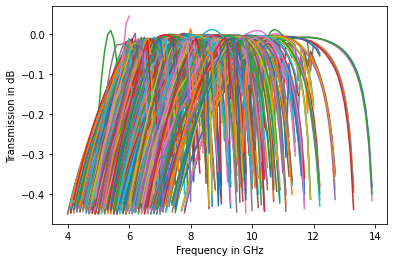

In [12]:
begin = 0
stop = np.inf
for i, index in enumerate(indices):
  if i>=begin and i<=stop:
    start = index_range[i][0]
    end = index_range[i][1]
    plt.plot(data.iloc[start:end+1, 0], data.iloc[start:end+1, index])
plt.xlabel('Frequency in GHz', fontsize=10)
plt.ylabel('Transmission in dB', fontsize=10)

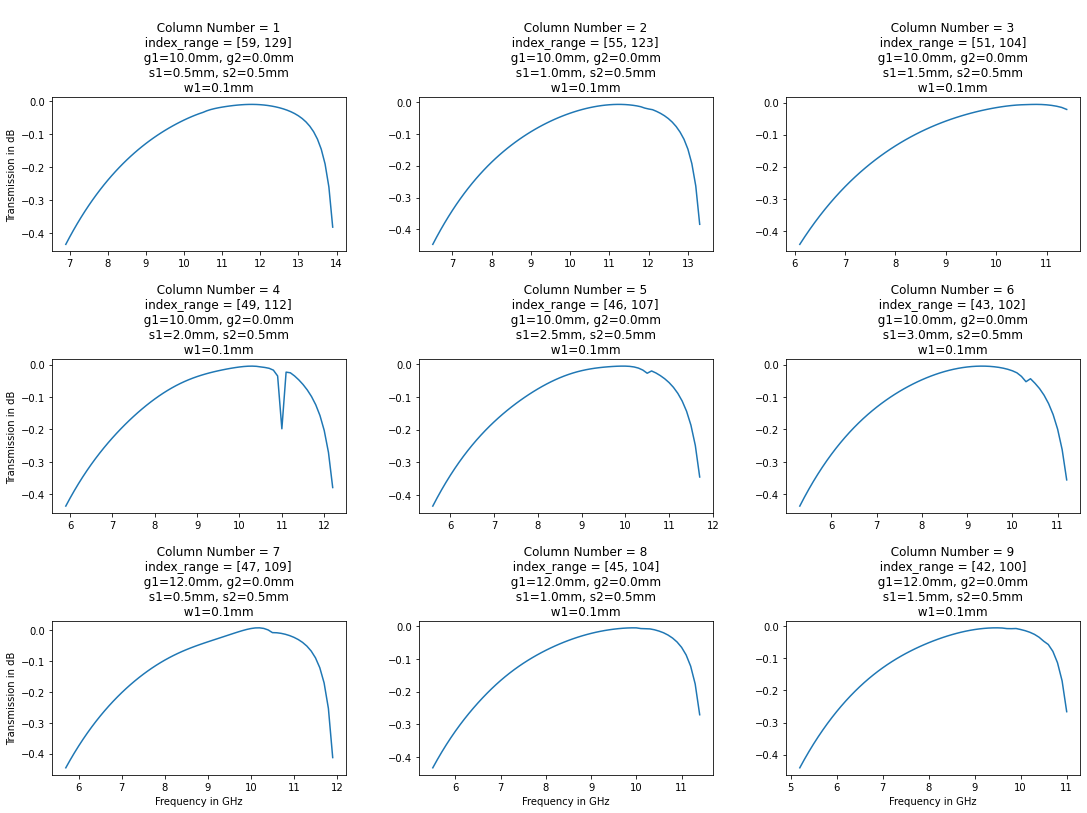

In [13]:
rows = 3
columns = 3
fig, window =  plt.subplots(rows, columns, figsize=(15,10))
fig.tight_layout()
for x in range(0,rows):
    for y in range(0, columns):
        position = x*columns+y
        column_index = indices[position]
        start = index_range[position][0]
        end = index_range[position][1]
        params=input_data[position]
        window[x][y].plot(data.iloc[start:end+1, 0], data.iloc[start:end+1, column_index])
        if inp_data_params == 4:
          window[x][y].title.set_text('''
          Column Number = %d
          index_range = [%d, %d]
          g1=%.1fmm, g2=%.1fmm
          s1=%.1fmm, s2=%.1fmm''' 
          % (column_index, start, end, *params))
        if inp_data_params == 5:
          window[x][y].title.set_text('''
          Column Number = %d
          index_range = [%d, %d]
          g1=%.1fmm, g2=%.1fmm
          s1=%.1fmm, s2=%.1fmm
          w1=%.1fmm''' 
          % (column_index, start, end, *params))
plt.subplots_adjust(wspace=0.25, hspace=0.7)
plt.setp(window[-1, :], xlabel='Frequency in GHz');
plt.setp(window[:, 0], ylabel='Transmission in dB');

In [14]:
Normalize=True
normalized_output = np.copy(output_data)
if Normalize:
  mean=[]
  sigma=[]
  for column in range(0,2):
    m = np.mean(output_data[:,column])
    s = np.max(output_data[:,column]) - np.min(output_data[:,column])
    mean.append(m)
    sigma.append(s)
    normalized_output[:,column]=(output_data[:,column]-m)/s
normalized_output[0:10,:]

array([[ 0.32545484,  0.65631587],
       [ 0.22019168,  0.58314514],
       [ 0.11492853,  0.35143782],
       [ 0.06229695,  0.4489988 ],
       [-0.01665042,  0.38802319],
       [-0.09559779,  0.32704758],
       [ 0.00966537,  0.41241343],
       [-0.04296621,  0.35143782],
       [-0.12191358,  0.30265733],
       [-0.17454516,  0.26607197]])

In [15]:
Normalize_input=True
normalized_input = np.copy(input_data)
if Normalize_input:
  input_mean=[]
  input_sigma=[]
  for column in range(0,4):
      m = np.mean(input_data[:,column])
      s = np.max(input_data[:,column]) - np.min(input_data[:,column])
      if s == 0:
        s=1e-9
      input_mean.append(m)
      input_sigma.append(s)
      normalized_input[:,column]=(input_data[:,column]-m)/s
normalized_input

array([[-0.5, -0.5, -0.5, -0.5,  0.1],
       [-0.5, -0.5, -0.3, -0.5,  0.1],
       [-0.5, -0.5, -0.1, -0.5,  0.1],
       ...,
       [ 0.5,  0.5,  0.1,  0.5,  0.5],
       [ 0.5,  0.5,  0.3,  0.5,  0.5],
       [ 0.5,  0.5,  0.5,  0.5,  0.5]])

In [16]:

cleaned_data = np.concatenate((input_data, output_data), axis=1)
if inp_data_params == 4:
  cleaned_data = pd.DataFrame(cleaned_data, columns=['g1 (mm)', 'g2 (mm)',
                                                   's1 (mm)', 's2 (mm)', 
                                                   'freq1 (GHz)', 'freq2 (GHz)'])
if inp_data_params == 5:
  cleaned_data = pd.DataFrame(cleaned_data, columns=['g1 (mm)', 'g2 (mm)',
                                                   's1 (mm)', 's2 (mm)', 
                                                   'w1 (mm)',
                                                   'freq1 (GHz)', 'freq2 (GHz)'])
cleaned_data

,g1 (mm),g2 (mm),s1 (mm),s2 (mm),w1 (mm),freq1 (GHz),freq2 (GHz)
0,10.0,0.0,0.5,0.5,0.1,6.9,13.9
1,10.0,0.0,1.0,0.5,0.1,6.5,13.3
2,10.0,0.0,1.5,0.5,0.1,6.1,11.4
3,10.0,0.0,2.0,0.5,0.1,5.9,12.2
4,10.0,0.0,2.5,0.5,0.1,5.6,11.7
...,...,...,...,...,...,...,...
643,14.0,0.2,1.0,2.0,0.5,5.3,6.7
644,14.0,0.2,1.5,2.0,0.5,5.1,6.5
645,14.0,0.2,2.0,2.0,0.5,5.0,6.4
646,14.0,0.2,2.5,2.0,0.5,4.9,6.0


In [17]:
for index in range(0,inp_data_params):
  print(cleaned_data[cleaned_data.columns[index]].value_counts())

14.0    216
12.0    216
10.0    216
Name: g1 (mm), dtype: int64
0.2    216
0.1    216
0.0    216
Name: g2 (mm), dtype: int64
3.0    108
2.5    108
2.0    108
1.5    108
1.0    108
0.5    108
Name: s1 (mm), dtype: int64
2.0    162
1.5    162
1.0    162
0.5    162
Name: s2 (mm), dtype: int64
0.3    216
0.1    216
0.5    216
Name: w1 (mm), dtype: int64


In [18]:
def data(inp, op):
  return train_test_split(inp, op, test_size=0.2,
                          random_state=42,
                          shuffle=True)
def learn(epochs, seed=0):
  tf.random.set_seed(seed)
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(8,input_shape=(inp_data_params,),activation='relu'))
  model.add(tf.keras.layers.Dense(32,activation='relu'))
  model.add(tf.keras.layers.Dense(2,activation='tanh'))
  model.compile(loss=tf.keras.losses.LogCosh(), optimizer='adam')
  history=model.fit(X_train, y_train, validation_split=0.25, epochs=epochs,
                    verbose=0, shuffle=True)
  return model, history

In [19]:
def input(inp, mean, sigma, Normalize):
  if Normalize:
    op=np.copy(inp)
    for column in range(0,4):
      op[:,column] = (inp[:,column]-mean[column])/(sigma[column])
    return op
  return inp
    
def output(prediction, mean, sigma, Normalize):
  if Normalize:
    op=np.copy(prediction[:])
    for column in range(0,2):
          op[:,column] = (prediction[:,column]*sigma[column])+mean[column]
    return op
  return prediction

In [20]:
#Good Seeds: 0, 5, 983, 732
acceptable_loss = 0.30
epochs = 300
max_count = 0
initial_seed = random.randint(0, 1000)
from sklearn.metrics import mean_absolute_error as mae
X_train, X_test, y_train, y_test = data(normalized_input, normalized_output)
model, history = learn(epochs, initial_seed)
prediction = output(model.predict(X_test), mean, sigma, Normalize)
y = output(y_test, mean, sigma, Normalize)
test_loss = mae(prediction, y)
min_loss_states=[]
while test_loss >= acceptable_loss and max_count>0:
  print("Test Loss very high, trying again. [test loss = %f]" % test_loss)
  X_train, X_test, y_train, y_test = data(normalized_input, normalized_output)
  ran_val = random.randint(1,1000)
  model, history = learn(epochs, ran_val)
  prediction = output(model.predict(X_test), mean, sigma, Normalize)
  y = output(y_test, mean, sigma, Normalize)
  test_loss = mae(prediction, y)
  min_loss_states.append([ran_val, test_loss])
  max_count = max_count - 1
print("test loss c1= %f, precision= %0.1f" % (mae(prediction[:,0], y[:,0]), 0.1))
print("test loss c2= %f, precision= %0.1f" % (mae(prediction[:,1], y[:,1]), 0.1))
print("test loss avg= %f" % test_loss)
min_loss_states.sort(key=lambda state: state[1])
print(min_loss_states)


test loss c1= 0.073800, precision= 0.1
test loss c2= 0.151835, precision= 0.1
test loss avg= 0.112817
[]


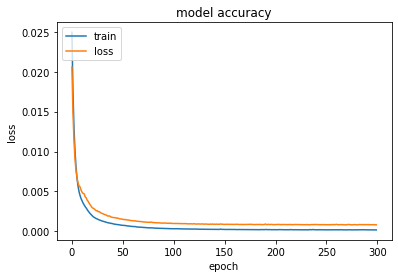

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'loss'], loc='upper left')
plt.show()

In [22]:
inp=input_data[30:40]
normal_input = input(inp, input_mean, input_sigma, Normalize_input)
normal_output = model.predict(normal_input)
result = output(normal_output, mean, sigma, Normalize)
result = result.round(1)
result = np.where(result<=0, 0, result)
print(result)
print(output_data[30:40])

[[ 5.3 10.1]
 [ 5.1  9.8]
 [ 4.8  9.4]
 [ 4.7  9.1]
 [ 4.6  8.8]
 [ 4.5  8.7]
 [ 7.7 12.1]
 [ 7.4 12. ]
 [ 7.1 11.6]
 [ 6.7 11.1]]
[[ 5.4 10.1]
 [ 5.2  9.8]
 [ 4.8  9.5]
 [ 4.8  9.2]
 [ 4.7  8.9]
 [ 4.5  8.8]
 [ 7.7 12. ]
 [ 7.4 12.2]
 [ 7.  11.7]
 [ 6.7 11.3]]


In [23]:
g1_range = np.arange(9.5, 14.6, 0.50)
g2_range = np.arange(0.0, 0.31, 0.020)
s1_range = np.arange(0.25, 3.6, 0.15)
s2_range = np.arange(0.25, 2.6, 0.15)
w1_range = np.arange(0.0, 0.61, 0.05)
combs = []
for x in g1_range:
  for y in g2_range:
    for z in s1_range:
      for w in s2_range:
        for u in s2_range:
          arr = [x, y, z, w, u]
          combs.append(arr)
combs=np.array(combs)
print("total_points = %d" % combs.shape[0])

total_points = 1036288


In [24]:
inp = input(combs, input_mean, input_sigma, Normalize_input)
normal_output = model.predict(inp)
frequencies = output(normal_output, mean, sigma, Normalize)
frequencies = frequencies.round(3)
frequencies = np.where(frequencies<=0, 0, frequencies)
print(combs.shape)
print(frequencies.shape)

(1036288, 5)
(1036288, 2)


In [25]:
df = np.concatenate((frequencies, combs), axis=1)
df = pd.DataFrame(data=df, columns=["F1", "F2", "G1", "G2", "S1", "S2", "W1"])
#df.to_excel("Design2a_Para2_S21_DB.xlsx", index=False)

In [26]:
#files.download("Design2a_Para2_S21_DB.xlsx")

In [27]:
print("frequency working range => f1 -> (%0.1f, %0.1f), f2 -> (%0.1f, %0.1f)"% \
      (df.iloc[:,0].min(),df.iloc[:,0].max(),df.iloc[:,1].min(),df.iloc[:,1].max()))

frequency working range => f1 -> (3.6, 8.2), f2 -> (5.3, 13.8)


In [28]:
def find_best_match(frequencies, sizes, input):
  min_error = 100
  index = -1
  for ind, frequency in enumerate(frequencies):
    error = (abs(frequency[0]-input[0])+abs(frequency[1]-input[1]))/2
    if error < min_error:
      min_error = error
      index = ind
  e1 = abs(frequencies[index][0]-input[0])
  e2 = abs(frequencies[index][1]-input[1])
  return sizes[index], min_error, e1, e2

In [29]:
inps = np.array([[2,4],[3,5],[6,8],[8,10],[10,12],[12,14],[14,16],[16,18],[8,12],[6,14],[8,18]], dtype=np.float)
for index, input in enumerate(inps):
  op1 = find_best_match(frequencies, combs,  input)
  op2 = find_best_match(output_data, input_data,  input)
  if op2[1] < op1[1] or op2[1] < test_loss:
    op1 = op2
  print('[%4.1f, %4.1f]' % tuple(inps[index]), '[%5.2f, %5.2f, %5.2f, %5.2f, %5.2f]' % tuple(op1[0]), 'eea = %0.2f, ee1 = %0.2f ee2 = %0.2f' %op1[1:])

[ 2.0,  4.0] [14.50,  0.18,  3.55,  0.25,  0.25] eea = 1.66, ee1 = 1.81 ee2 = 1.51
[ 3.0,  5.0] [14.50,  0.18,  3.55,  0.25,  0.25] eea = 0.66, ee1 = 0.81 ee2 = 0.51
[ 6.0,  8.0] [10.00,  0.10,  2.50,  1.00,  0.50] eea = 0.00, ee1 = 0.00 ee2 = 0.00
[ 8.0, 10.0] [ 9.50,  0.08,  0.25,  2.35,  0.70] eea = 0.01, ee1 = 0.01 ee2 = 0.00
[10.0, 12.0] [ 9.50,  0.00,  0.25,  2.05,  0.25] eea = 0.96, ee1 = 1.89 ee2 = 0.03
[12.0, 14.0] [ 9.50,  0.00,  0.25,  0.70,  0.25] eea = 2.59, ee1 = 4.52 ee2 = 0.66
[14.0, 16.0] [ 9.50,  0.00,  0.25,  0.70,  0.25] eea = 4.59, ee1 = 6.52 ee2 = 2.66
[16.0, 18.0] [ 9.50,  0.00,  0.25,  0.70,  0.25] eea = 6.59, ee1 = 8.52 ee2 = 4.66
[ 8.0, 12.0] [ 9.50,  0.00,  0.25,  2.50,  1.75] eea = 0.01, ee1 = 0.01 ee2 = 0.01
[ 6.0, 14.0] [ 9.50,  0.00,  1.45,  0.25,  0.55] eea = 0.43, ee1 = 0.20 ee2 = 0.66
[ 8.0, 18.0] [ 9.50,  0.00,  0.25,  0.70,  0.25] eea = 2.59, ee1 = 0.52 ee2 = 4.66


In [30]:
f_range = np.arange(1.0, 20.1, 0.1)
freq_combs = []
size = f_range.shape[0]
for x in range(0,size):
  for y in range(x+2, size):
      arr = [f_range[x],f_range[y]]
      freq_combs.append(arr)
freq_combs = np.array(freq_combs)
print("frequency combinations = %d" % freq_combs.shape[0])
count = 0
for input in freq_combs:
  op=find_best_match(output_data, input_data,  input)
  if op[1] < test_loss:
    count = count + 1
print("combinations for which ML model is not needed = %d" % count)

frequency combinations = 17955
combinations for which ML model is not needed = 1579


In [31]:
#  model.save('good.h5')
# files.download('good.h5')